In [1]:
import numpy as np
import pandas as pd
import statistics as st
import matplotlib.pyplot as plt
import seaborn as sns
import random

dataset = pd.read_csv('ParisHousingClass.csv')
dataset.head()

,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,price,category
0,75523,3,0,1,63,9373,3,8,2005,0,1,4313,9005,956,0,7,7559081.5,Basic
1,80771,39,1,1,98,39381,8,6,2015,1,0,3653,2436,128,1,2,8085989.5,Luxury
2,55712,58,0,1,19,34457,6,8,2021,0,0,2937,8852,135,1,9,5574642.1,Basic
3,32316,47,0,0,6,27939,10,4,2012,0,1,659,7141,359,0,3,3232561.2,Basic
4,70429,19,1,1,90,38045,3,7,1990,1,0,8435,2429,292,1,4,7055052.0,Luxury


In [2]:
df = dataset

cols_drop = ['cityPartRange', 'hasStormProtector', 'cityCode','numPrevOwners', 'hasStorageRoom', 'hasGuestRoom', 'made', 'attic', 'garage', 'floors', 'price']
df = df.drop(columns=cols_drop)
print(df.columns)

X=df.iloc[:,:len(df.columns) - 1]
y=df.iloc[:,len(df.columns) - 1]
X,y

Index(['squareMeters', 'numberOfRooms', 'hasYard', 'hasPool', 'isNewBuilt',
       'basement', 'category'],
      dtype='object')


(      squareMeters  numberOfRooms  hasYard  hasPool  isNewBuilt  basement
 0            75523              3        0        1           0      4313
 1            80771             39        1        1           1      3653
 2            55712             58        0        1           0      2937
 3            32316             47        0        0           0       659
 4            70429             19        1        1           1      8435
 ...            ...            ...      ...      ...         ...       ...
 9995          1726             89        0        1           0      9311
 9996         44403             29        1        1           0      9061
 9997         83841              3        0        0           1      8304
 9998         59036             70        0        0           0      2590
 9999          1440             84        0        0           1      8485
 
 [10000 rows x 6 columns],
 0        Basic
 1       Luxury
 2        Basic
 3        Basic
 4     

           Specs         Score
0   squareMeters  23113.275374
5       basement   2103.057446
3        hasPool    738.120545
4     isNewBuilt    728.017987
2        hasYard    687.162430
1  numberOfRooms      0.032271


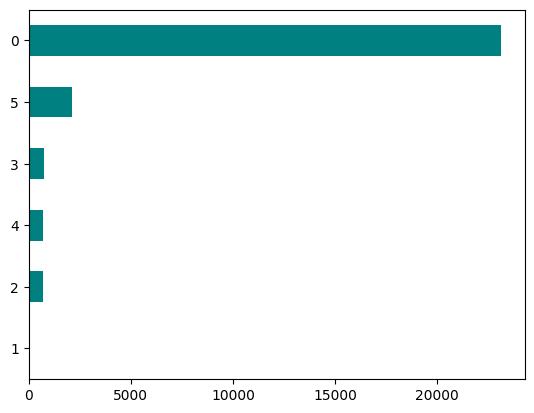

In [3]:
# анализ важности признаков в наборе данных X с помощью критерия хи-квадрат
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

bestfeatures = SelectKBest(score_func=chi2, k='all')
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

#объединим два фрейма данных для лучшей визуализации
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #название показателей
print(featureScores.nlargest(11,'Score'))

feature_importances = pd.Series(featureScores['Score'])
feature_importances = feature_importances.sort_values(ascending=True)
feature_importances.plot(kind='barh', color='teal')
plt.show()

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score

# разбиваем набор данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(df.drop('category', axis=1), df['category'], test_size=0.3,random_state=42)

# создаем список признаков
col_list = X_train.select_dtypes(include=['number']).columns
print(col_list)
print(X_train.shape, y_train.shape)

Index(['squareMeters', 'numberOfRooms', 'hasYard', 'hasPool', 'isNewBuilt',
       'basement'],
      dtype='object')
(7000, 6) (7000,)


In [5]:
# вычисляем AUC для модели с одним признаком,
# используя перекрестную проверку
# (Area Under the Curve) - определяем качество
log = LogisticRegression(solver='liblinear')
auc=cross_val_score(log, X_train, y_train, cv=5, scoring='roc_auc')

# превращаем список со значениями AUC в серию
auc_values = pd.Series(auc)
print(auc_values)

0    0.556707
1    0.739420
2    0.546057
3    0.485234
4    0.478797
dtype: float64


In [6]:

# сортируем по убыванию
auc_values = auc_values.sort_values(ascending=False)
auc_values

1    0.739420
0    0.556707
2    0.546057
3    0.485234
4    0.478797
dtype: float64

In [7]:
# формитруем датасет только из информативных показателей
x_1=X.iloc[:,auc_values.index]#3
x_1

,numberOfRooms,squareMeters,hasYard,hasPool,isNewBuilt
0,3,75523,0,1,0
1,39,80771,1,1,1
2,58,55712,0,1,0
3,47,32316,0,0,0
4,19,70429,1,1,1
...,...,...,...,...,...
9995,89,1726,0,1,0
9996,29,44403,1,1,0
9997,3,83841,0,0,1
9998,70,59036,0,0,0


## Рекурсивное исключение признаков

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE

threshold = 5 # the number of most relevant features

lr = LogisticRegression(class_weight = 'balanced', solver = 'lbfgs', random_state=42, n_jobs=-1, max_iter=1000)

rfe = RFE(lr, n_features_to_select=5)
rfe=rfe.fit(X, y)
# X_train, y_train - входные и выходные данные с обучающей выборки соответственно.
selector_ind = rfe.get_support()
df_rfe = X.iloc[:, selector_ind]
print(df_rfe.columns)

Index(['numberOfRooms', 'hasYard', 'hasPool', 'isNewBuilt', 'basement'], dtype='object')


In [9]:
# Теперь вычислим важности признаков на основе информационного выигрыша.
from lightgbm import LGBMClassifier
from sklearn.model_selection import (train_test_split,
                                     cross_val_score,
                                     cross_validate)

# создаем экземляр класса LGBMClassifier
model_all_features = LGBMClassifier(
    random_state=42, learning_rate=0.01,
    n_estimators=300, bagging_fraction=0.5,
    feature_fraction=1, lambda_l1=10,
    importance_type='gain')

# выполняем перекрестную проверку и сохраняем результат
# с помощью функции cross_validate()
output = cross_validate(
    model_all_features, X_train, y_train, cv=5,
    scoring='roc_auc', return_estimator=True)

# создаем список fi, в который будем сохранять
# важности признаков, и сохраняем в него важности,
# рассчитанные для каждой из моделей
fi = []
for estimator in output['estimator']:
    fi.append(estimator.feature_importances_)

# преобразовываем список в датафрейм, индексы в котором
# будут именами наших переменных
fi = pd.DataFrame(
    np.array(fi).T,
    columns=['importance ' + str(idx)
             for idx in range(len(fi))],
    index=X_train.columns)
# вычисляем усредненные важности и добавляем столбец с ними
fi['mean_importance'] = fi.mean(axis=1)
# смотрим полученный датафрейм
fi

[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Info] Number of positive: 699, number of negative: 4901
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000166 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 617
[LightGBM] [Info] Number of data points in the train set: 560

,importance 0,importance 1,importance 2,importance 3,importance 4,mean_importance
squareMeters,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
numberOfRooms,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
hasYard,75467.585099,76065.812384,71451.457752,75347.344769,76601.938366,74986.827674
hasPool,51531.227392,62891.646573,53039.810218,49904.278972,51996.245718,53872.641775
isNewBuilt,63103.937428,51144.667648,65437.994991,64668.315072,61313.294209,61133.641870
basement,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


## Финальная выборка

In [10]:
need = ['hasYard', 'hasPool', 'isNewBuilt']

df_filtered = df[need]
df_filtered

,hasYard,hasPool,isNewBuilt
0,0,1,0
1,1,1,1
2,0,1,0
3,0,0,0
4,1,1,1
...,...,...,...
9995,0,1,0
9996,1,1,0
9997,0,0,1
9998,0,0,0
